In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
data.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [3]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [4]:
# Read sample
sample_ct   = read_nii(data.loc[1,'ct_scan'])
sample_lung = read_nii(data.loc[1,'lung_mask'])
sample_infe = read_nii(data.loc[1,'infection_mask'])
sample_all  = read_nii(data.loc[1,'lung_and_infection_mask'])

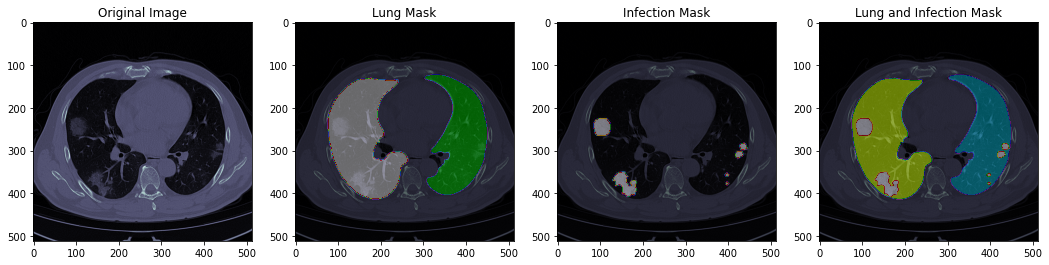

Text(0.5, 1.0, 'Lung and Infection Mask')

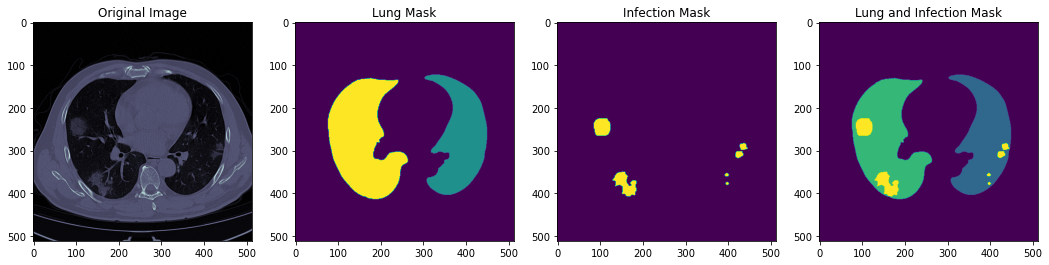

In [5]:
n =100

fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_lung[..., n],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_infe[..., n], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_all[..., n], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

plt.show()


fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)

plt.imshow(sample_lung[..., n])
plt.title('Lung Mask')

plt.subplot(1,4,3)

plt.imshow(sample_infe[..., n])
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_all[..., n])
plt.title('Lung and Infection Mask')

In [6]:
sample_ct[:,:,1].shape

(512, 512)

In [7]:
set(sample_all[:,:,100].reshape((512*512)).tolist())

{0.0, 1.0, 2.0, 3.0}

* 0 - background
* 1 - left
* 2 - right
* 3 - infect

In [8]:
set(sample_infe[:,:,100].reshape((512*512)).tolist())

{0.0, 1.0}

* 0 - background
* 1 - infect

## Load Data

In [9]:
import math

In [52]:
from tensorflow.keras.utils import Sequence

class DataSequence(Sequence):
    """
    Keras Sequence object to train a model on a list of csv files
    """
    def __init__(self, data, batch_size=2, mode='train'):
        """
        df = dataframe with two columns: the labels and a list of filenames
        """
        
        self.bsz = batch_size
        self.mode = mode
        self.ind = np.arange(batch_size)
        
        # Take labels and a list of image locations in memory
        self.data = data
        

    def __len__(self):
        return int(math.ceil((self.data.shape[0]) / float(self.bsz)))

    def on_epoch_end(self):
        self.indexes = range(self.data.shape[0])
        if self.mode == 'train':
            # Shuffles indexes after each epoch if in training mode
            self.indexes = np.random.choice(self.indexes, size=len(self.indexes))

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        #idx * self.bsz: (idx + 1) * self.bsz
       
        imag = read_nii(data.loc[idx,'lung_and_infection_mask'])
        batch =[]
        for i in range(imag.shape[2]):
            
            imag4 = np.zeros((imag.shape[0],imag.shape[1],3))

            imag4[:,:,0] = imag[:,:,i]==1 
            imag4[:,:,1] = imag[:,:,i]==2 
            imag4[:,:,2] = imag[:,:,i]==3
            
            batch.append(imag4[100:300,100:300,:])
        self.ind = np.random.choice(np.arange(len(batch)), size=self.bsz )
        print(type(self.ind))
        self.segment = np.array(batch)[self.ind].astype(float)    
        return self.segment

    def get_batch_features(self, idx):
        # Fetch a batch of inputs
        imag = read_nii(data.loc[idx,'ct_scan'])
        imag = imag.transpose([2,0,1]) / 255
        imag =imag.reshape(imag.shape[0],imag.shape[1],imag.shape[2],1)
        return imag[self.ind,100:300,100:300,:]

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [53]:
data_seq = DataSequence(data.iloc[:3,:],10)
data_seq_test = DataSequence(data.iloc[-2:,:],10)
x,y = data_seq[0]
print(x.shape)
print(y.shape)


<class 'numpy.ndarray'>
(10, 200, 200, 1)
(10, 200, 200, 3)


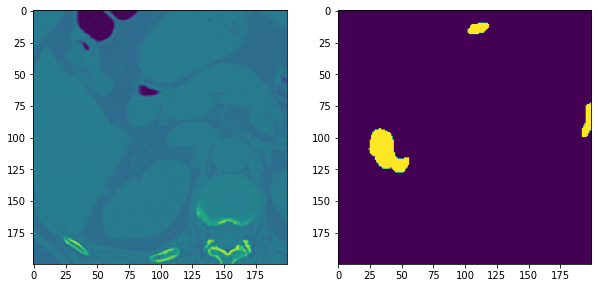

In [54]:
n = 4
fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(x[n,:,:,0])
plt.subplot(1,2,2)
plt.imshow(y[n,:,:,2])

plt.show()

In [19]:
from sklearn.model_selection import train_test_split


In [20]:
import cv2
import skimage.color
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from keras import backend as K
from PIL import Image
import tensorflow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers  import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [21]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [22]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [62]:
def unet_pre_train(num_classes = 13, input_shape= (200, 200, 3), lr=0.0001,b1 = 0.9, b2=0.9999):  
    # грузим   VGG16
    #pre_trained_model = VGG16(input_shape=(input_shape[0],input_shape[1],3), include_top=False, weights="imagenet")
    # замораживаем все слои
    # layer in pre_trained_model.layers[:18]:
    #  layer.trainable = False
    # фиксируем последний рабочий слой для своего потока  
    #x = pre_trained_model.layers[13].output
    # фиксируем скипы для переноса из VGG16 (надо еще проверять)
    #block_4_out = pre_trained_model.layers[10].output
    #block_3_out = pre_trained_model.layers[6].output
    #block_2_out = pre_trained_model.layers[3].output
    #  фиксируем вход сети
    img_input = Input(shape = input_shape)
    #x = Conv2D(3, (3, 3), padding='same')(img_input )
    #pre_trained_model.layers[0].input = x                                      
    #x = pre_trained_model.layers[0].output
    x = img_input
    print(x)
    
    blocks = []
    i = 0

    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    blocks4 = x
    print('i: ',i,x)
    i +=1
    # down i
    x = MaxPooling2D(padding='same')(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    blocks3 = x  
    print('i: ',i,x)
    i +=1
    # down i
    
    x = MaxPooling2D(padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    blocks2 = x  
    print('i: ',i,x)
    i +=1
    # down i
    
    x = MaxPooling2D(padding='same')(x)
    
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(126, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # задаем список скипов 
    #blocks = [block_4_out, block_3_out, block_2_out]
    
    #print(block_4_out)
    #print(block_3_out)
    #print(block_2_out)
    
    blocks1 = x
    blocks = [blocks4,blocks3,blocks2,blocks1]
    print(blocks)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    print(x)
    #x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)

    print(x)
    for i in [3,2,1]:
      x = concatenate([x, blocks[i]] ) # добавили перенос из понижаюшего плеча VGG16
      x = Conv2D(32*i, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(32*i, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      # UP i
      x = Conv2DTranspose(32*i, (2, 2), strides=(2, 2), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

    print(x)
    # последний слой сверток для классификации
    x = concatenate([x, blocks[0]] )
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if num_classes>1:
      x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
      # собираем модель 
      model = Model(img_input, x)
      model.compile(optimizer=Adam(),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
    else:
      x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
      # собираем модель 
      model = Model(img_input, x)
      model.compile(optimizer=Adam(learning_rate=lr, beta_1=b1, beta_2=b2),
                    loss = 'mse',
                    metrics=[dice_coef])

    model.summary()
    # вернем модель
    return model

In [63]:
im_size=x[0,:,:,:].shape
model= unet_pre_train(num_classes = 3, input_shape= (im_size[0], im_size[1], im_size[2]))

Tensor("input_5:0", shape=(None, 200, 200, 1), dtype=float32)
i:  0 Tensor("activation_85/Identity:0", shape=(None, 200, 200, 16), dtype=float32)
i:  1 Tensor("activation_87/Identity:0", shape=(None, 100, 100, 32), dtype=float32)
i:  2 Tensor("activation_89/Identity:0", shape=(None, 50, 50, 64), dtype=float32)
[<tf.Tensor 'activation_85/Identity:0' shape=(None, 200, 200, 16) dtype=float32>, <tf.Tensor 'activation_87/Identity:0' shape=(None, 100, 100, 32) dtype=float32>, <tf.Tensor 'activation_89/Identity:0' shape=(None, 50, 50, 64) dtype=float32>, <tf.Tensor 'activation_91/Identity:0' shape=(None, 25, 25, 126) dtype=float32>]
Tensor("activation_93/Identity:0", shape=(None, 25, 25, 256), dtype=float32)
Tensor("activation_93/Identity:0", shape=(None, 25, 25, 256), dtype=float32)
Tensor("activation_102/Identity:0", shape=(None, 200, 200, 32), dtype=float32)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)     

In [64]:
es = EarlyStopping(monitor = ['dice_coef'], patience = 3)

In [65]:
history = model.fit_generator(data_seq, epochs=10, verbose=1,validation_data = data_seq_test)

<class 'numpy.ndarray'>
Epoch 1/10
<class 'numpy.ndarray'>
1/1 [==============================] - ETA: 0s - loss: 0.2836 - dice_coef: 0.0842<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1/1 [==============================] - 5s 5s/step - loss: 0.2836 - dice_coef: 0.0842 - val_loss: 0.2286 - val_dice_coef: 0.1173
Epoch 2/10
<class 'numpy.ndarray'>
1/1 [==============================] - ETA: 0s - loss: 0.2824 - dice_coef: 0.1591<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1/1 [==============================] - 4s 4s/step - loss: 0.2824 - dice_coef: 0.1591 - val_loss: 0.3457 - val_dice_coef: 0.1847
Epoch 3/10
<class 'numpy.ndarray'>
1/1 [==============================] - ETA: 0s - loss: 0.2636 - dice_coef: 0.1828<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1/1 [==============================] - 4s 4s/step - loss: 0.2636 - dice_coef: 0.1828 - val_loss: 0.3510 - val_dice_coef: 0.1878
Epoch 4/10
<class 'numpy.ndarray'>
1/1 [==============================] - ETA: 0s - loss: 0.2412 - d

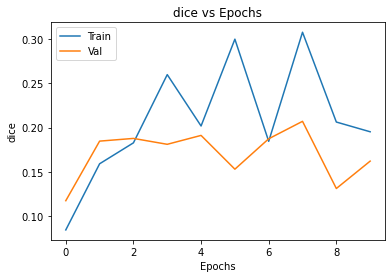

In [66]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('dice')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

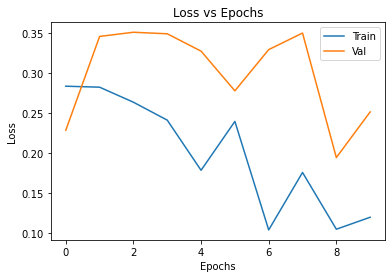

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

predicted masks

In [71]:
X,Y = data_seq_test[0]

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'predicted infection mask')

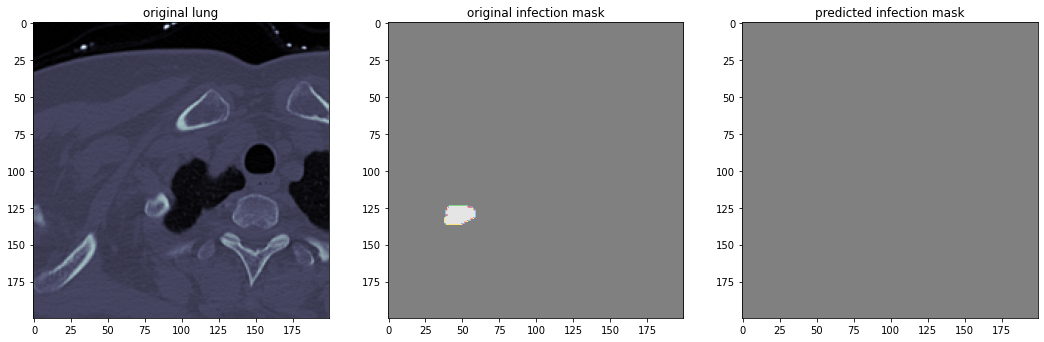

In [72]:
predicted = model.predict(X)
n = 5
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(X[n][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
#plt.imshow(X[n][...,0], cmap = 'bone')
plt.imshow(Y[n][...,2],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
#plt.imshow(X[n][...,0], cmap = 'bone')
plt.imshow((predicted[n,:,:,2]>0.5).astype(float),alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Пока не очень